In [ ]:
!pip install torch_geometric --quiet
!pip install optuna --quiet

In [ ]:
import torch
from torch_geometric.datasets import KarateClub
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from torch.nn import Linear
from torch_geometric.utils import to_networkx
from torch_geometric.nn import GCNConv
import pandas as pd

In [ ]:
dataset = KarateClub()
data = dataset[0]

In [ ]:
node_features_df = pd.DataFrame(data.x.numpy(),columns = (f"f_{i}" for i in range (1,35)))
node_features_df['node'] = node_features_df.index
node_features_df.set_index('node',inplace=True)

edge_features_df = pd.DataFrame(data.edge_index.numpy().T , columns = ('source' , 'target'))

labels_df = pd.DataFrame(data.y.numpy())
labels_df['node'] = labels_df.index
labels_df.set_index('node',inplace = True)

In [ ]:
node_features_df.head()

,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,...,f_25,f_26,f_27,f_28,f_29,f_30,f_31,f_32,f_33,f_34
node,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
data.num_edges

156

In [ ]:
edge_features_df.head()

,source,target
0,0,1
1,0,2
2,0,3
3,0,4
4,0,5


In [ ]:
num_countries = 4;
np.random.seed(42)
countries = torch.tensor(np.random.choice(num_countries , data.num_nodes))
data.y = countries

In [ ]:
print("shape of y:",data.y.shape)
print(data.num_nodes)
print("shape of x:",data.x.shape)
print(data)

shape of y: torch.Size([34])
34
shape of x: torch.Size([34, 34])
Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])


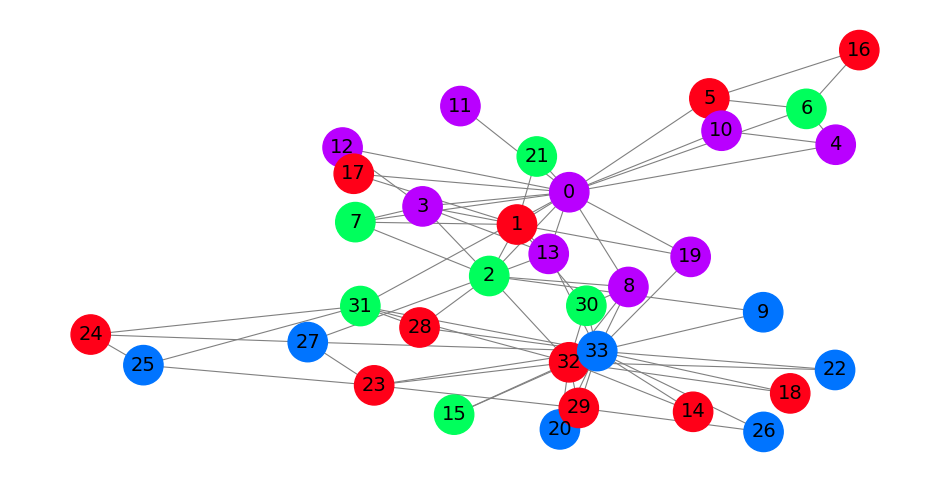

In [ ]:
G = to_networkx(data , to_undirected = True)
plt.figure(figsize = (12,6))
plt.axis('off')
nx.draw_networkx(G,
                 pos = nx.spring_layout(G,seed=0),
                 with_labels = True,
                 node_size =800,
                 node_color = data.y,
                 cmap = "hsv",
                 vmin = -2,
                 vmax =3,
                 width = 0.8,
                 edge_color = "grey",
                 font_size =14
                 )

plt.show()

In [ ]:
class GCN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.gcn = GCNConv(data.num_features , 4)
    self.out = Linear(4 , num_countries , bias = False)

  def forward(self , x ,edge_index):
    h = self.gcn(x , edge_index)
    z = self.out(h)

    return h , z

model = GCN()
model

GCN(
  (gcn): GCNConv(34, 4)
  (out): Linear(in_features=4, out_features=4, bias=False)
)

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters() , lr = 0.01)

def accuracy(pred_y , y):
  return (pred_y == y).sum()/len(y)

In [ ]:
embeddings = []
losses = []
accuracy_list = []
outputs = []

for epoch in range(200):
  optimizer.zero_grad()
  h , z = model(data.x , data.edge_index)
  loss = criterion(z , data.y)
  acc = accuracy(z.argmax(dim =1),data.y)
  loss.backward()
  optimizer.step()

  embeddings.append(h)
  losses.append(loss)
  accuracy_list.append(acc)
  outputs.append(z.argmax(dim = 1))

  if epoch % 10 == 0:
    print(f"epoch:{epoch} | loss:{loss} | accuracy:{acc}")


epoch:0 | loss:1.3926362991333008 | accuracy:0.20588235557079315
epoch:10 | loss:1.3229525089263916 | accuracy:0.47058823704719543
epoch:20 | loss:1.239856481552124 | accuracy:0.529411792755127
epoch:30 | loss:1.1358619928359985 | accuracy:0.5588235259056091
epoch:40 | loss:1.0218099355697632 | accuracy:0.6470588445663452
epoch:50 | loss:0.9105371236801147 | accuracy:0.6764705777168274
epoch:60 | loss:0.8077136278152466 | accuracy:0.7058823704719543
epoch:70 | loss:0.7146545648574829 | accuracy:0.7352941036224365
epoch:80 | loss:0.6310683488845825 | accuracy:0.7647058963775635
epoch:90 | loss:0.556126058101654 | accuracy:0.8235294222831726
epoch:100 | loss:0.4881596267223358 | accuracy:0.9117646813392639
epoch:110 | loss:0.42604875564575195 | accuracy:0.9117646813392639
epoch:120 | loss:0.3690377473831177 | accuracy:0.9117646813392639
epoch:130 | loss:0.3172876536846161 | accuracy:0.970588207244873
epoch:140 | loss:0.2715774476528168 | accuracy:0.970588207244873
epoch:150 | loss:0.2323

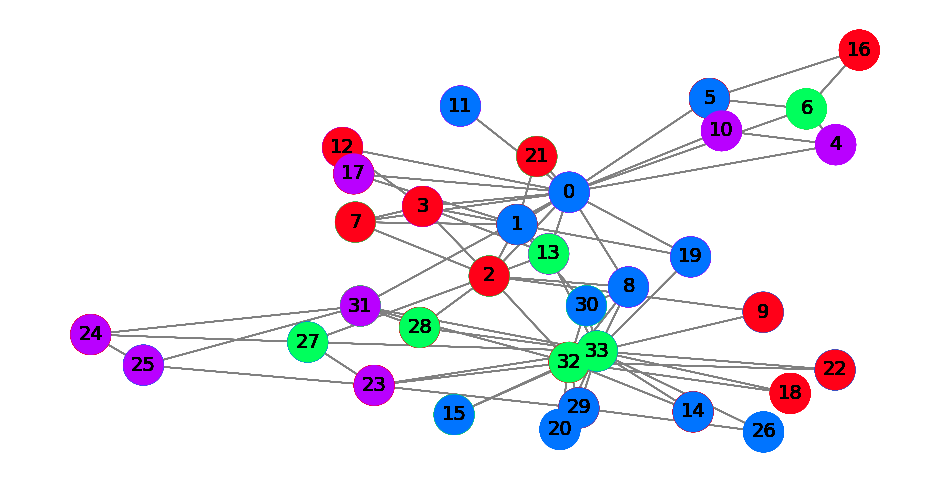

In [ ]:
from IPython.display import HTML
from matplotlib import animation

plt.rcParams["animation.bitrate"] = 3000

def animate(i):
  G = to_networkx(data , to_undirected = True)
  nx.draw_networkx(G,
                 pos = nx.spring_layout(G,seed=0),
                 with_labels = True,
                 node_size =800,
                 node_color = outputs[i].numpy(),
                 cmap = "hsv",
                 vmin = -2,
                 vmax =3,
                 width = 0.8,
                 edge_color = "grey",
                 font_size =14
                 )

fig = plt.figure(figsize = (12,6))
plt.axis('off')
anim = animation.FuncAnimation(fig , animate , np.arange(0,200,10) , interval = 500 , repeat = True)
html = HTML(anim.to_html5_video())
display(html)


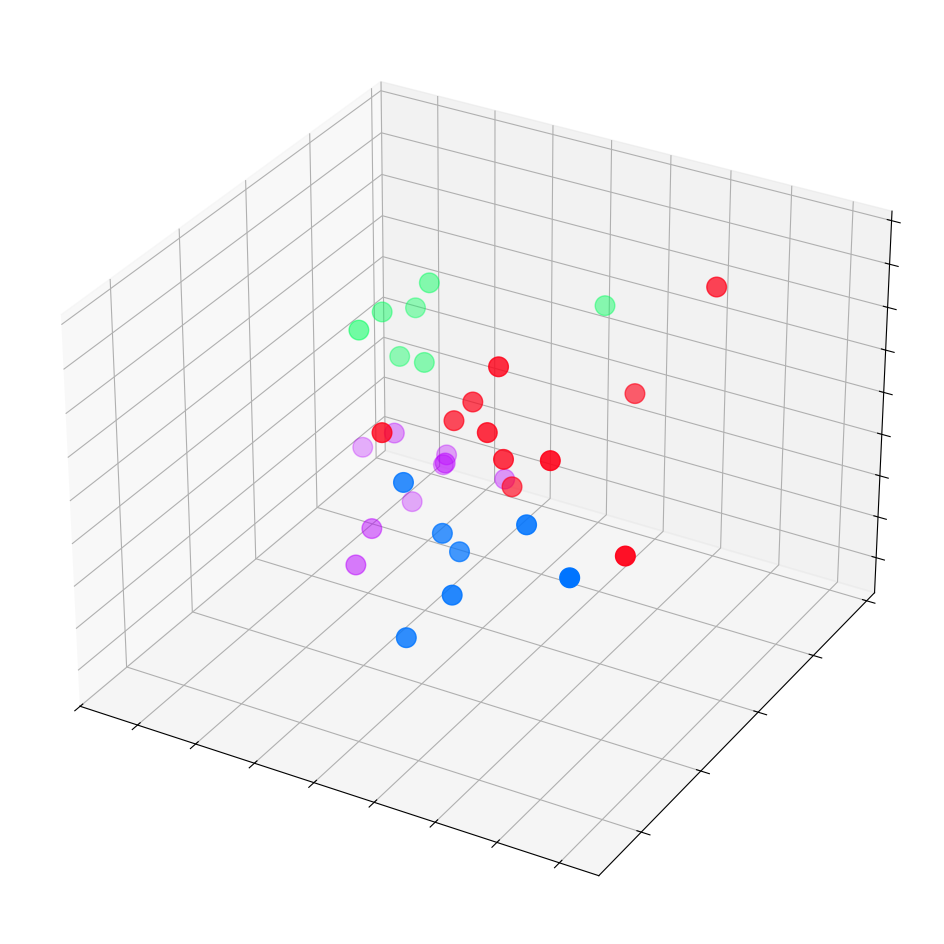

In [ ]:
embed = h.detach().cpu().numpy()
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(projection = '3d')
ax.patch.set_alpha(0)
plt.tick_params(left = False , bottom = False , labelleft = False , labelbottom = False)
ax.scatter(embed[:,0],embed[:,1],embed[:,2],
           s =200 , c=data.y,cmap="hsv",vmin =-2,vmax=3)
plt.show()